# [Capstone Project] ML for Healthcare

Nathan Hartzell


## Dataset loading and necessary imports

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

ECG_train = pd.read_pickle('ECG5000_train.pickle')
ECG_vld = pd.read_pickle('ECG5000_validation.pickle')

print(ECG_train.shape)
print("first sample: ", ECG_train[1])
print("first col sample 10: ", ECG_train[9][0])

(500, 141)
first sample:  [ 0.0000000e+00 -1.1008778e+00 -3.9968398e+00 -4.2858426e+00
 -4.5065789e+00 -4.0223767e+00 -3.2343676e+00 -1.5661258e+00
 -9.9225766e-01 -7.5467971e-01  4.2321173e-02  1.4895093e-01
  1.8352707e-01  2.9487608e-01  1.9023267e-01  2.3557500e-01
  2.5348712e-01  2.2174240e-01  5.0233259e-02  1.7804214e-01
  1.3956318e-01  4.6794433e-02  4.3007139e-02  1.0654432e-01
  1.2654003e-02  3.9948539e-03  4.5724179e-02 -4.5999362e-02
 -7.2666959e-02 -7.1077909e-02 -1.5386649e-01 -2.2725443e-01
 -2.4926970e-01 -2.5348935e-01 -3.3283516e-01 -2.6432996e-01
 -3.4582525e-01 -3.1078107e-01 -3.3415978e-01 -3.0617791e-01
 -1.7456252e-01 -2.0616017e-01 -2.2447967e-01 -4.8683931e-02
 -1.9621159e-02  9.4805186e-02  1.1678639e-01  1.8518592e-01
  2.3052577e-01  1.3802707e-01  2.4442554e-01  2.7169477e-01
  2.5900331e-01  2.6920166e-01  1.2706463e-01  2.0207339e-01
  2.5598343e-01  1.5311526e-01  2.1021583e-01  1.9108187e-01
  1.9092702e-01  2.1051006e-01  2.0710764e-01  2.0488835e-0

## Separating samples from labels

In [5]:
# split data into X and y
y_trn = ECG_train[:, 0]
X_trn = ECG_train[:, 1:]

y_vld = ECG_vld[:, 0]
X_vld = ECG_vld[:, 1:]

print(X_trn.shape)
print(y_trn.shape)


(500, 140)
(500,)


## Data Preprocessing -- scaling

In [11]:
scaler = StandardScaler()

X_trn_scaled = scaler.fit_transform(X_trn)
X_vld_scaled = scaler.transform(X_vld)

## install pytorch if necessary

In [139]:
!pip install torch

<h1>CNN model in pytorch</h1> 

from the article -- 3 convolution layers for feature extraction and 2 MLP layers for classification

In [279]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ECG1DCNN(nn.Module):
    def __init__(self):
        super(ECG1DCNN, self).__init__()

        # 3 convolutional layers used by research paper
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(32)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)

        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(128)

        # global pooling 
        self.global_pool = nn.AdaptiveMaxPool1d(1)

        # MLP layers used by research paper
        self.fc1 = nn.Linear(128, 64)  
        self.dropout = nn.Dropout(0.3)
        # linear output layer (5 classes)
        self.fc2 = nn.Linear(64, 5)    

    def forward(self, x):
        # forward function using relu and convolution layers
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        # pooling
        x = self.global_pool(x).squeeze(-1)  # Shape: (batch_size, 128)
        # MLP layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        # logits for 5 classes
        x = self.fc2(x)  
        return x


<h2>Convert training data to tensors and dataloaders for model training</h2>

In [23]:
from torch.utils.data import TensorDataset, DataLoader

X_trn_cnn = torch.tensor(X_trn_scaled, dtype=torch.float32).unsqueeze(1)  # shape (N, 1, 140)
y_trn_cnn = torch.tensor(y_trn, dtype=torch.long)
X_vld_cnn = torch.tensor(X_vld_scaled, dtype=torch.float32).unsqueeze(1)
y_vld_cnn = torch.tensor(y_vld, dtype=torch.long)

trn_ds = TensorDataset(X_trn_cnn, y_trn_cnn)
vld_ds = TensorDataset(X_vld_cnn, y_vld_cnn)
trn_loader = DataLoader(trn_ds, batch_size=64, shuffle=True)
vld_loader = DataLoader(vld_ds, batch_size=64)

<h2>select loss function and use Adam optimizer</h2>

In [226]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ECG1DCNN().to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5

<h2> train the model using specified number of epochs </h2>

In [228]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, preds = torch.max(outputs, dim=1)  # Get the predicted class labels
        correct_preds += (preds == y_batch).sum().item()  # Count correct predictions
        total_preds += y_batch.size(0)  # Total number of samples in the batch

    avg_loss = running_loss / len(train_loader)
    epoch_acc = correct_preds / total_preds
    print("epoch: ",epoch+1, " training accuracy: ", epoch_acc)

epoch:  1  training accuracy:  0.482
epoch:  2  training accuracy:  0.704
epoch:  3  training accuracy:  0.81
epoch:  4  training accuracy:  0.87
epoch:  5  training accuracy:  0.92


<h2>Predict validation data and calculate metrics</h2>

In [276]:
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()


with torch.no_grad():
    # get raw outputs from the model
    outputs = model(X_vld_cnn.to(device))
    # predict most likely class
    preds = torch.argmax(outputs, dim=1) 

predictions = preds.cpu()  
true_labels = y_vld_cnn.cpu() 

# get true labels and predicted labels
true_labels = true_labels.numpy()
predictions = predictions.numpy()

In [212]:
acc = np.mean(true_labels == predictions)
recall = recall_score(true_labels, predictions, average='macro')
precision = precision_score(true_labels, predictions, average='macro')
f1 = f1_score(true_labels, predictions, average='macro')

cf_matrix = confusion_matrix(true_labels, predictions)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [215]:
print("Accuracy: {:.4f}".format(acc))
print("Precision (macro): {:.4f}".format(precision))
print("Recall (macro): {:.4f}".format(recall))
print("F1 Score (macro): {:.4f}".format(f1))

Accuracy: 0.9120
Precision (macro): 0.6167
Recall (macro): 0.5208
F1 Score (macro): 0.5512


Text(50.722222222222214, 0.5, 'True Labels')

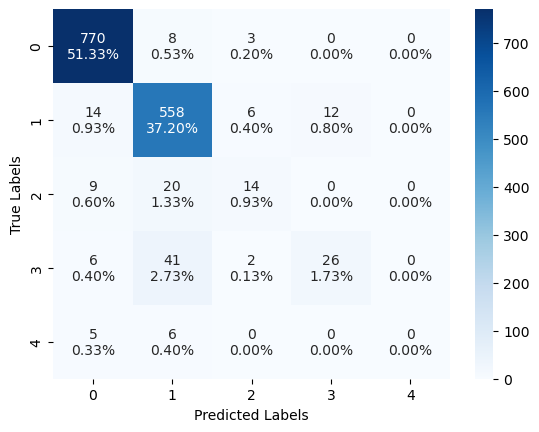

In [205]:
plt.figure(dpi=100)

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2, in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(5,5)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

<h1>Naive Bayes Classification</h1>
<p>A gaussian naive bayes classifier will be trained to test the claim of the second paper that this type of model can have an accuraccy up to 99%</p>


<b> setting up datasets </b>
<p> bringing forward the ECG5000 scaled datasets and relabeling them as varables for NB</p>

In [237]:
X_trn_nb = X_trn_scaled
y_trn_nb = y_trn
X_vld_nb = X_vld_scaled
y_vld_nb = y_vld

<b> Setting up gaussian naive bayes classifier </b>
<p>importing the necessary sklearn utitilites to train a gnb classifier</p>

In [249]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
nb_preds = gnb.fit(X_trn_nb, y_trn_nb).predict(X_vld_nb)

In [255]:
acc = np.mean(y_vld_nb == nb_preds)
recall = recall_score(y_vld_nb, nb_preds, average='macro')
precision = precision_score(y_vld_nb, nb_preds, average='macro')
f1 = f1_score(y_vld_nb, nb_preds, average='macro')

cf_matrix_nb = confusion_matrix(y_vld_nb, nb_preds)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [253]:
print("Accuracy: {:.4f}".format(acc))
print("Precision (macro): {:.4f}".format(precision))
print("Recall (macro): {:.4f}".format(recall))
print("F1 Score (macro): {:.4f}".format(f1))

Accuracy: 0.8580
Precision (macro): 0.4840
Recall (macro): 0.5472
F1 Score (macro): 0.5006


Text(50.722222222222214, 0.5, 'True Labels')

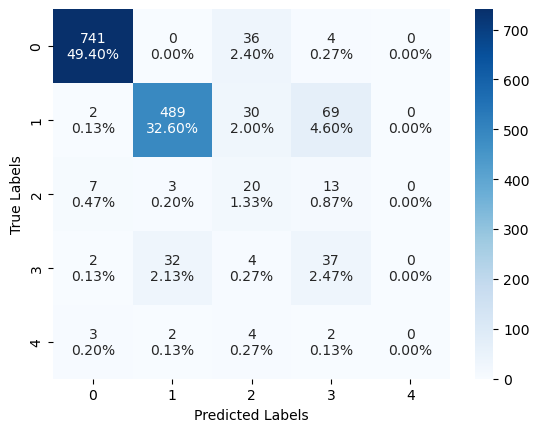

In [257]:
plt.figure(dpi=100)

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix_nb.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix_nb.flatten()/np.sum(cf_matrix_nb)]
labels = [f"{v1}\n{v2}" for v1, v2, in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(5,5)
sns.heatmap(cf_matrix_nb, annot=labels, fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')